<a href="https://colab.research.google.com/github/HananeMaghlazi/P8_BigData/blob/main/P8_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction : 

La très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.


* A noter que le projet va être réalisé en 2 temps, dans deux environnements différents.

* Sur ce notebook nous allons dans un premier temps développer et exécuter notre code en local,en travaillant sur un nombre limité d'images à traiter.

* Une fois les choix techniques validés, nous déploierons notre solution dans un environnement Big Data en mode distribué.

In [1]:
# Monter le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check de la version java

In [ ]:
!java --version

openjdk 11.0.17 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


# Installation des pakages necessaires avec pip

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=82694175304ad459a471f17a67febed75b81c56ca45f9c53390479a7c033e315
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


# Import des librariries

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import pathlib
import PIL
import time
import seaborn as sns
import matplotlib.pyplot as plt
# For tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# For Pyspark
from pyspark.ml.feature import StandardScaler, StringIndexer
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import PCA as PCAml
from pyspark.sql.types import *

# Création de la SparkSession

In [4]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Affichage des informations de Spark en cours d'execution

In [ ]:
spark

Création de la variable "sc" qui est un SparkContext issue de la variable spark

In [5]:
sc = spark.sparkContext

In [ ]:
sc

<SparkContext master=local appName=P8>

# Chargement des images

In [6]:
data_dir = pathlib.Path("/content/drive/MyDrive/Fruits")
data_dir

PosixPath('/content/drive/MyDrive/Fruits')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Le dossier contient",image_count,"images")

Le dossier contient 100 images


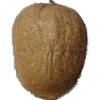

In [8]:
Kiwi = list(data_dir.glob('Kiwi/*'))
PIL.Image.open(str(Kiwi[2]))

Chargement des données:
Importer les images dans un dataframe pandas UDF

- Les images sont chargées au format binaire, pour plus de souplesse dans la façon de prétraiter les images
- charger uniquement les fichiers dont l'extension est jpg

In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/content/drive/MyDrive/Fruits")

- Affichage des 20 premières images contenant :
  - le path de l'image

  - la date et heure de sa dernière modification : modificationtime

  - sa longueur : length

  - son contenu encodé en valeur hexadécimal: content

In [ ]:
images.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/dri...|2021-09-12 17:26:38|  5452|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5446|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5423|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5420|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5415|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5409|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5404|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5402|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5398|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5397|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5386|[FF D8 FF E0 00 1...|
|file:

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------+------+
|path                                                |label |
+----------------------------------------------------+------+
|file:/content/drive/MyDrive/Fruits/Orange/1_100.jpg |Orange|
|file:/content/drive/MyDrive/Fruits/Orange/17_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/0_100.jpg |Orange|
|file:/content/drive/MyDrive/Fruits/Orange/19_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/18_100.jpg|Orange|
+----------------------------------------------------+------+
only showing top 5 rows

None


# Préparation du modèle

- Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée

Nous créons un nouveau modèle avec:

en entrée : l'entrée du modèle MobileNetV2

en sortie : l'avant dernière couche du modèle MobileNetV2

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle)

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. 

Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser 
ensuite les poids aux différents workeurs.

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

Mettre le tout en fonction : 

In [11]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF : 

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [12]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


# Exécuter la featurisation sur l'ensemble de notre DataFrame Spark

In [13]:
%time
features_df = images.repartition(10).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [ ]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [ ]:
features_df.show(5)

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|file:/content/dri...|          Kiwi|[1.2349986, 7.897...|
|file:/content/dri...|          Kiwi|[0.58461845, 0.0,...|
|file:/content/dri...|          Kiwi|[0.6616302, 0.0, ...|
|file:/content/dri...|        Orange|[0.16999188, 0.0,...|
|file:/content/dri...|Apple Braeburn|[0.8586179, 0.029...|
+--------------------+--------------+--------------------+
only showing top 5 rows



# Réduction de dimension de type PCA en PySpark

In [ ]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [14]:
# Transform array to vector for PCA
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
features_vect = features_df.select('path', 'label', ud_f('features').alias('features_vec'))

In [18]:
features_vect.show(5)

+--------------------+--------------+--------------------+
|                path|         label|        features_vec|
+--------------------+--------------+--------------------+
|file:/content/dri...|          Kiwi|[1.23499858379364...|
|file:/content/dri...|          Kiwi|[0.58461844921112...|
|file:/content/dri...|          Kiwi|[0.66163021326065...|
|file:/content/dri...|        Orange|[0.16999188065528...|
|file:/content/dri...|Apple Braeburn|[0.85861790180206...|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [15]:
# Standardiser les données avant la PCA
standardizer = StandardScaler(withMean=True, withStd=True,inputCol="features_vec", outputCol="features_scaled")
model = standardizer.fit(features_vect)
result = model.transform(features_vect)
features_vect_scaled= result.select('path', 'label', 'features_scaled')

In [21]:
features_vect_scaled.show(5)

+--------------------+--------------+--------------------+
|                path|         label|     features_scaled|
+--------------------+--------------+--------------------+
|file:/content/dri...|          Kiwi|[1.69318157229807...|
|file:/content/dri...|          Kiwi|[-0.0969223261427...|
|file:/content/dri...|          Kiwi|[0.11504457093870...|
|file:/content/dri...|        Orange|[-1.2381389736120...|
|file:/content/dri...|Apple Braeburn|[0.65723276281695...|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [39]:
# PCA 
pca = PCAml(k=50, inputCol="features_scaled", outputCol="features_pca")
model = pca.fit(features_vect_scaled)
features_df_pca = model.transform(features_vect_scaled)

In [40]:
model.explainedVariance.sum()

0.9259594325806088

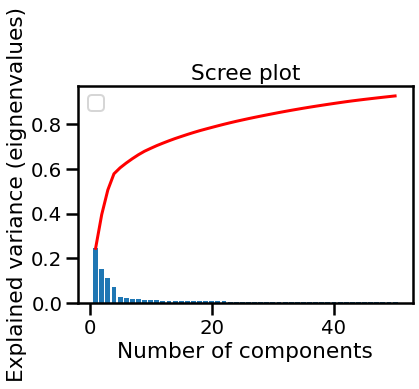

In [41]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(model.explainedVariance)+1),
    model.explainedVariance
    )
 
plt.plot(
    range(1,len(model.explainedVariance )+1),
    np.cumsum(model.explainedVariance),
    c='red',
    )
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

In [23]:
features_df_pca.show(5)

+--------------------+--------------+--------------------+--------------------+
|                path|         label|     features_scaled|        features_pca|
+--------------------+--------------+--------------------+--------------------+
|file:/content/dri...|          Kiwi|[1.69318157229807...|[-23.001705422550...|
|file:/content/dri...|          Kiwi|[-0.0969223261427...|[-18.775337502007...|
|file:/content/dri...|          Kiwi|[0.11504457093870...|[-21.340003628173...|
|file:/content/dri...|        Orange|[-1.2381389736120...|[8.82959818084494...|
|file:/content/dri...|Apple Braeburn|[0.65723276281695...|[20.0847013752276...|
+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



In [26]:
# Je ne garde que les features après PCA
features_df_pca= features_df_pca.select('path', 'label', 'features_pca')
features_df_pca.show(5)

+--------------------+--------------+--------------------+
|                path|         label|        features_pca|
+--------------------+--------------+--------------------+
|file:/content/dri...|          Kiwi|[-23.001705422550...|
|file:/content/dri...|          Kiwi|[-18.775337502007...|
|file:/content/dri...|          Kiwi|[-21.340003628173...|
|file:/content/dri...|        Orange|[8.82959818084494...|
|file:/content/dri...|Apple Braeburn|[20.0847013752276...|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [27]:
features_df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_pca: vector (nullable = true)



In [28]:
# vector to array

features_df_pca = features_df_pca.withColumn("features_pca", vector_to_array("features_pca"))
features_df_pca = features_df_pca.select('path', 'label', 'features_pca')

In [29]:
features_df_pca.show(5)

+--------------------+--------------+--------------------+
|                path|         label|        features_pca|
+--------------------+--------------+--------------------+
|file:/content/dri...|          Kiwi|[-23.001705422550...|
|file:/content/dri...|          Kiwi|[-18.775337502007...|
|file:/content/dri...|          Kiwi|[-21.340003628173...|
|file:/content/dri...|        Orange|[8.82959818084494...|
|file:/content/dri...|Apple Braeburn|[20.0847013752276...|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [30]:
features_df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features_pca: array (nullable = false)
 |    |-- element: double (containsNull = false)



# Enregistrement des données traitées au format "parquet"

In [31]:
# Enregistrement des données traitées au format "parquet" :
features_df_pca.write.mode("overwrite").parquet("/content/drive/MyDrive/Results")

In [32]:
# Lecture du fichier sous format dataframe
df = pd.read_parquet("/content/drive/MyDrive/Results")

In [33]:
df.head() 

,path,label,features_pca
0,file:/content/drive/MyDrive/Fruits/Kiwi/11_100...,Kiwi,"[-23.001705422550998, -23.434864635608747, -7...."
1,file:/content/drive/MyDrive/Fruits/Kiwi/20_100...,Kiwi,"[-18.775337502007613, -15.325581945717852, -3...."
2,file:/content/drive/MyDrive/Fruits/Kiwi/21_100...,Kiwi,"[-21.34000362817379, -17.934325840560035, -4.7..."
3,file:/content/drive/MyDrive/Fruits/Orange/11_1...,Orange,"[8.829598180844942, -5.001467196879154, 22.308..."
4,file:/content/drive/MyDrive/Fruits/Apple Braeb...,Apple Braeburn,"[20.08470137522769, 2.922259530239061, -13.426..."


# Export sous csv

In [34]:
# Export sous csv
%time
df_pca = features_df_pca.toPandas()
df_pca.to_csv("/content/drive/MyDrive/Results/result.csv",index=False)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 23.6 µs


In [35]:
# Lecture du fichier csv
df_final = pd.read_csv("/content/drive/MyDrive/Results/result.csv")

In [36]:
df_final.head()

,path,label,features_pca
0,file:/content/drive/MyDrive/Fruits/Kiwi/11_100...,Kiwi,"[-23.001705422550998, -23.434864635608747, -7...."
1,file:/content/drive/MyDrive/Fruits/Kiwi/20_100...,Kiwi,"[-18.775337502007613, -15.325581945717852, -3...."
2,file:/content/drive/MyDrive/Fruits/Kiwi/21_100...,Kiwi,"[-21.34000362817379, -17.934325840560035, -4.7..."
3,file:/content/drive/MyDrive/Fruits/Orange/11_1...,Orange,"[8.829598180844942, -5.001467196879154, 22.308..."
4,file:/content/drive/MyDrive/Fruits/Apple Braeb...,Apple Braeburn,"[20.08470137522769, 2.922259530239061, -13.426..."


# Conclusion : 

Nous venons de valider le processus sur un jeu de données allégé en local où nous avons simulé un cluster de machines en répartissant la charge de travail sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution sur un réel cluster de machines et nous travaillerons sur un nombre plus important d'images.
